In [4]:

%pip install -U stable-baselines3 sb3-contrib

import os
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import motornet as mn
import utils
import agents
import task
import plot
from importlib import reload
reload(agents)
reload(utils)
reload(task)
reload(plot)
from utils import load_env, load_policy, calc_loss, run_rollout
from task import CentreOutFF, CentreOutFFGym
from agents import SLAgent
from stable_baselines3.common.vec_env import DummyVecEnv
# from plot import plot_simulations

from sb3_contrib import RecurrentPPO


Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name 'get_device' from partially initialized module 'stable_baselines3.common.utils' (most likely due to a circular import) (/home/sungshinkim/anaconda3/envs/motornet/lib/python3.13/site-packages/stable_baselines3/common/utils.py)

In [186]:

device = th.device("cuda" if th.cuda.is_available() else "cpu")
config = 'parameters.json'
print(f"Using device: {device}")
with open(config, 'r') as f:
    config = json.load(f)

# --- parameters setting ---
env_params = config['env_params']
train_params = config['training_params']

# Define task and the effector
effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle())
env = CentreOutFF(effector=effector, **env_params)

n_input = env.observation_space.shape[0]
n_output = env.n_muscles



Using device: cuda


In [110]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations2(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  # plt.ylim([-.4, 0.6])
  # plt.xlim([-0.6, 0.6])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  # plt.ylim([-2, 2])
  # plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()


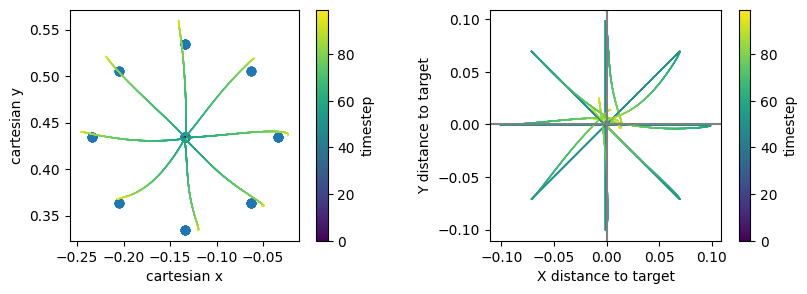

In [140]:
## Test the agent
device = 'cpu' # test model on CPU
agent = SLAgent(obs_dim=n_input, action_dim=n_output, device=device)
agent.load('./results/test1/agent_18500.pth')
data = run_rollout(env, agent, batch_size = 128, condition='test')
xy = data['xy'].detach().numpy() 
tg = data['tg'].detach().numpy()
# fg, ax = plt.subplots(nrows=1,ncols=1)
plot_simulations2(xy, tg)

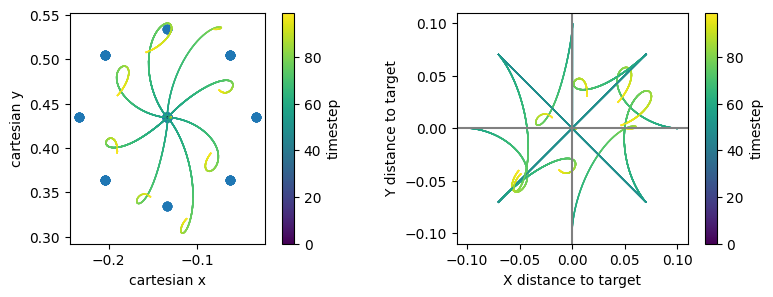

In [139]:
data = run_rollout(env, agent, batch_size = 128, condition='test',ff_coefficient = 8.)
xy = data['xy'].detach().numpy() 
tg = data['tg'].detach().numpy()
# fg, ax = plt.subplots(nrows=1,ncols=1)
plot_simulations2(xy, tg)

In [159]:
from stable_baselines3.common.env_checker import check_env
env_gym = CentreOutFFGym(effector=effector, **env_params)
check_env(env_gym, warn=True)

In [165]:
vec_env = DummyVecEnv([lambda: env_gym])
agent = RecurrentPPO("MlpLstmPolicy", vec_env, verbose=1)
agent.learn(total_timesteps=10000)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 159 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 74            |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 3.4924597e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -8.51         |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.8e+09       |
|    n_updates            | 10            |
|    policy_gradient_loss | -2.31e-05     |
|    std                  | 1             |
|    value_loss           | 5.6

In [188]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import time

class RewardCallback(BaseCallback):
    """
    훈련 중 매 에피소드가 끝날 때마다 보상을 기록하는 콜백.
    """
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.rewards = []

    def _on_step(self) -> bool:
        # info 딕셔너리에서 에피소드 정보 확인
        for info in self.locals.get("infos", []):
            if "episode" in info:
                # 에피소드 보상을 리스트에 추가
                episode_reward = info["episode"]["r"]
                self.rewards.append(episode_reward)
                if self.verbose > 0:
                    print(f"에피소드 종료! 보상: {episode_reward:.2f}")
        return True

print("CentreOutFFGym 래퍼 및 RewardCallback 클래스 정의 완료!")


CentreOutFFGym 래퍼 및 RewardCallback 클래스 정의 완료!


Using cuda device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -1.38e+06 |
| time/              |           |
|    fps             | 333       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 128       |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -9.04e+05    |
| time/                   |              |
|    fps                  | 157          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 7.450581e-09 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.51        |
|    explained_variance   | 0 

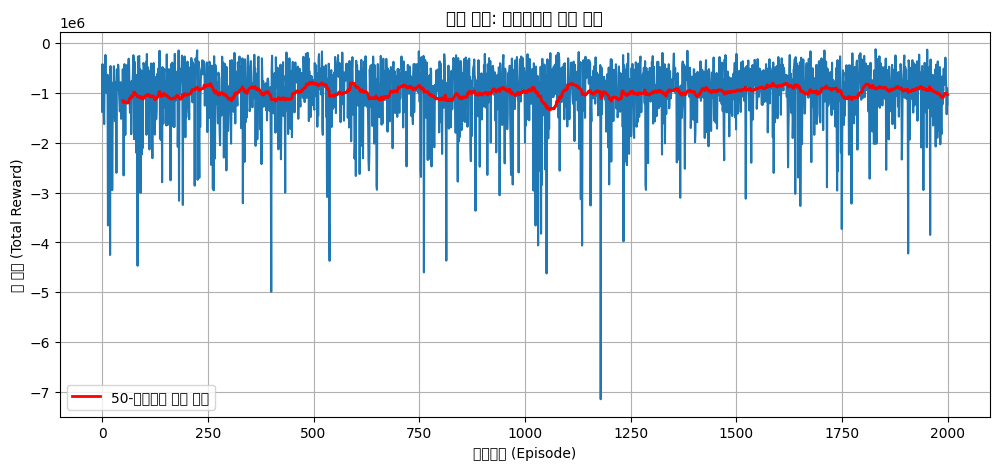

In [190]:
# [수정] 콜백 인스턴스 생성 (더 자주 체크)
reward_callback = RewardCallback()

# [수정] RecurrentPPO 모델 정의 시, 학습률과 훈련 스텝 수 조정
# TensorBoard 로그 디렉토리도 지정
model = RecurrentPPO(
    "MlpLstmPolicy", 
    vec_env, 
    verbose=1,
    learning_rate=1e-4,  # 학습률을 약간 낮춰 안정성 증가
)

# [수정] 훈련 스텝 수를 대폭 증가
total_training_steps = 200000
start_time = time.time()
model.learn(total_timesteps=total_training_steps, callback=reward_callback, tb_log_name="CentreOutFF_RecurrentPPO")
end_time = time.time()

print(f"\n훈련 완료! (소요 시간: {end_time - start_time:.2f}초)")

# ========================================================================================
# Cell 6: 학습 곡선(보상) 시각화
# ========================================================================================
print("\n[단계 3] 학습 곡선 시각화...")

if not reward_callback.rewards:
    print("경고: 기록된 보상이 없습니다. 훈련이 너무 짧거나 에피소드가 종료되지 않았을 수 있습니다.")
else:
    plt.figure(figsize=(12, 5))
    plt.title("학습 곡선: 에피소드별 보상 변화")
    plt.xlabel("에피소드 (Episode)")
    plt.ylabel("총 보상 (Total Reward)")
    plt.plot(reward_callback.rewards)

    window_size = 50
    if len(reward_callback.rewards) >= window_size:
        moving_avg = np.convolve(reward_callback.rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(np.arange(window_size-1, len(reward_callback.rewards)), moving_avg, label=f'{window_size}-에피소드 이동 평균', color='red', linewidth=2)
        plt.legend()

    plt.grid(True)
    plt.show()


In [ ]:
data['xy'].shape

torch.Size([8, 100, 2])


[단계 3] 학습 곡선 시각화...


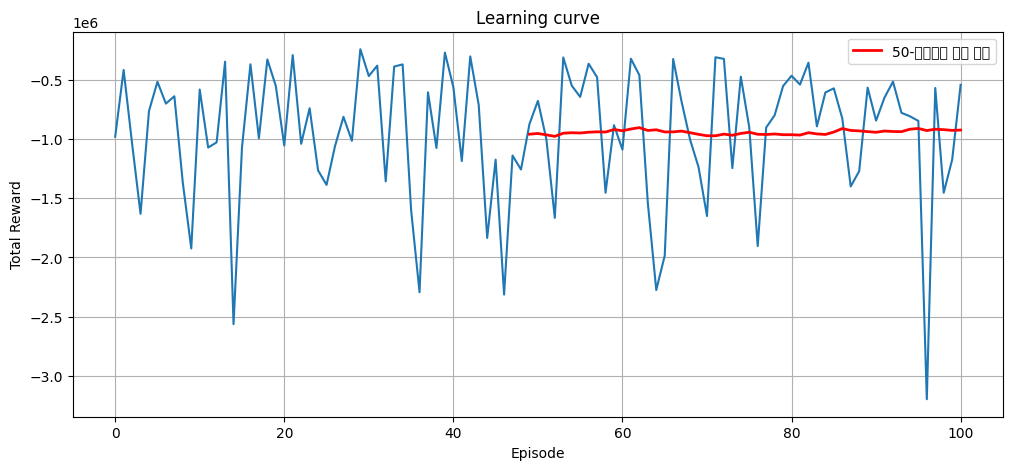

In [ ]:

# ========================================================================================
# Cell 6: [추가] 학습 곡선(보상) 시각화
# ========================================================================================
print("\n[단계 3] 학습 곡선 시각화...")

plt.figure(figsize=(12, 5))
plt.title("Learning curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
# 콜백에 저장된 보상 리스트를 플로팅합니다.
plt.plot(reward_callback.rewards)

# # 보상 추세를 더 잘 보기 위해 이동 평균(moving average)을 계산하여 함께 그립니다.
# window_size = 50
# if len(reward_callback.rewards) >= window_size:
#     moving_avg = np.convolve(reward_callback.rewards, np.ones(window_size)/window_size, mode='valid')
#     plt.plot(np.arange(window_size-1, len(reward_callback.rewards)), moving_avg, label=f'{window_size}-에피소드 이동 평균', color='red', linewidth=2)
#     plt.legend()

# plt.grid(True)
# plt.show()


[단계 3] 학습 곡선 시각화...


/home/sungshinkim/anaconda3/envs/motornet/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sungshinkim/anaconda3/envs/motornet/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sungshinkim/anaconda3/envs/motornet/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sungshinkim/anaconda3/envs/motornet/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


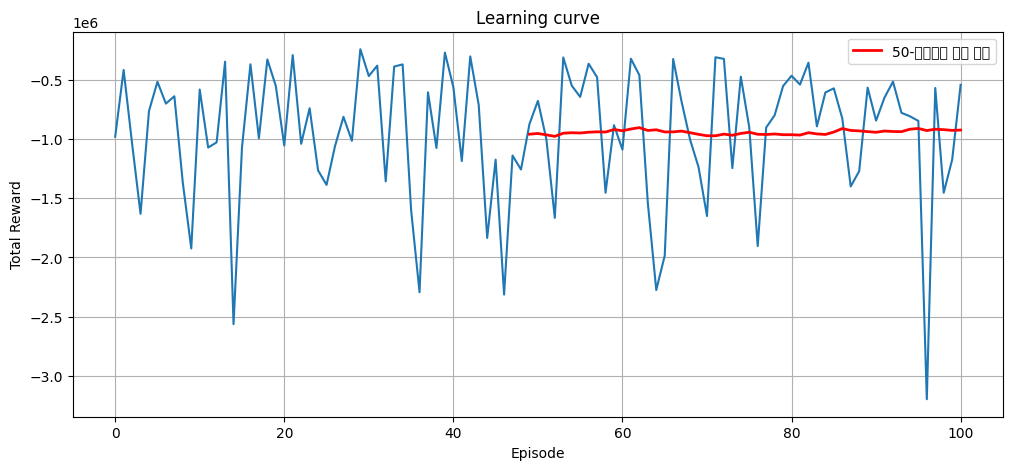


[단계 4] 훈련된 에이전트 평가 시작...
   - 평가 에피소드 종료. 총 보상: -63910.55
   - 평가 에피소드 종료. 총 보상: -54387.80

====== 모든 테스트가 성공적으로 완료되었습니다! ======


In [ ]:



# ========================================================================================
# Cell 7: 훈련된 에이전트 평가
# ========================================================================================

print("\n[단계 4] 훈련된 에이전트 평가 시작...")
obs = vec_env.reset()
# RecurrentPPO는 에피소드 시작 시 은닉 상태 리셋이 필요합니다.
lstm_states = None
num_envs = 1
episode_starts = np.ones((num_envs,), dtype=bool)
total_reward = 0

for i in range(200):
    action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    total_reward += reward[0]
    episode_starts = done
    if np.any(done):
        print(f"   - 평가 에피소드 종료. 총 보상: {total_reward:.2f}")
        total_reward = 0

env.close()
print("\n====== 모든 테스트가 성공적으로 완료되었습니다! ======")


In [ ]:
batch_size = 128
n_batch = 20000
losses = []
interval = 10
device = th.device("cuda" if th.cuda.is_available() else "cpu")
agent = SLAgent(obs_dim=n_input, action_dim=n_output, batch_size = batch_size, device=device)

for batch in range(n_batch):
    data = run_rollout(env, agent, batch_size=batch_size, device=device)
    loss = agent.update(data)
    losses.append(loss.item())

    if batch % interval == 0:
        avg = sum(losses[-interval:]) / len(losses[-interval:])  # Python float 평균
        print(f"Batch {batch}, Loss: {avg:.6f}")

Batch 0, Loss: 244.629013
Batch 10, Loss: 215.197780
Batch 20, Loss: 213.277055
Batch 30, Loss: 213.508365
Batch 40, Loss: 205.117561
Batch 50, Loss: 217.258887
Batch 60, Loss: 205.317537
Batch 70, Loss: 200.525197
Batch 80, Loss: 204.767581
Batch 90, Loss: 205.450362
Batch 100, Loss: 209.887082
Batch 110, Loss: 208.600537
Batch 120, Loss: 202.372105
Batch 130, Loss: 194.947829
Batch 140, Loss: 204.299207
Batch 150, Loss: 199.609152
Batch 160, Loss: 208.833443
Batch 170, Loss: 204.618181
Batch 180, Loss: 201.036871
Batch 190, Loss: 212.733647
Batch 200, Loss: 198.939685
Batch 210, Loss: 202.343854
Batch 220, Loss: 201.914203
Batch 230, Loss: 205.786514
Batch 240, Loss: 202.111743
Batch 250, Loss: 192.049518
Batch 260, Loss: 196.392998
Batch 270, Loss: 192.740025
Batch 280, Loss: 190.790805
Batch 290, Loss: 197.422760
Batch 300, Loss: 197.278680
Batch 310, Loss: 195.970227
Batch 320, Loss: 191.381975
Batch 330, Loss: 189.662456
Batch 340, Loss: 183.044022
Batch 350, Loss: 178.069807
Bat

In [ ]:
batch_size = 32
n_batch = 1000
losses = []
interval = 10

for batch in range(n_batch):
    data = run_episode(env, policy, batch_size=batch_size, ff_coefficient=0)
    overall_loss = calc_loss(data, loss_weight=None) # [1e+3,1e+5,1e-1,3e-4,1e-5,1e-3,0]
    # backward pass & update weights
    optimizer.zero_grad() 
    overall_loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()
    losses.append(overall_loss.item())

    if (batch % interval == 0) and (batch != 0):
        print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))



In [ ]:
batch_size = 32
n_batch = 1000
losses = []
interval = 10


def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

for batch in range(n_batch):
    h = policy.init_hidden(batch_size = batch_size)
    obs, info = env.reset(options={'batch_size':batch_size})
    terminated = False

    # initial poisitions and targets
    xy = [info["states"]["fingertip"][:, None, :]]
    tg = [info["goal"][:, None, :]]

    # simulate whole episode
    while not terminated:  # will run until `max_ep_duration` is reached
        action, h = policy(obs, h)
        obs, terminated, info = env.step(action=action)

        xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
        tg.append(info["goal"][:, None, :])  # targets

    # concatenate into a (batch_size, n_timesteps, xy) tensor
    xy = th.cat(xy, axis=1)
    tg = th.cat(tg, axis=1)
    # loss = calc_loss()
    loss = l1(xy, tg)

        # backward pass & update weights
    optimizer.zero_grad() 
    loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()
    losses.append(loss.item())

    if (batch % interval == 0) and (batch != 0):
        print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))

    

Batch 10/1000 Done, mean policy loss: 0.22079749554395675
Batch 20/1000 Done, mean policy loss: 0.20228872448205948
Batch 30/1000 Done, mean policy loss: 0.1795849546790123
Batch 40/1000 Done, mean policy loss: 0.17905158698558807
Batch 50/1000 Done, mean policy loss: 0.18864884376525878
Batch 60/1000 Done, mean policy loss: 0.1743134081363678
Batch 70/1000 Done, mean policy loss: 0.16410528719425202
Batch 80/1000 Done, mean policy loss: 0.1467793956398964
Batch 90/1000 Done, mean policy loss: 0.15351783782243728
Batch 100/1000 Done, mean policy loss: 0.15058071538805962
Batch 110/1000 Done, mean policy loss: 0.13508556559681892
Batch 120/1000 Done, mean policy loss: 0.13054453805088997
Batch 130/1000 Done, mean policy loss: 0.1418978191912174
Batch 140/1000 Done, mean policy loss: 0.13029820770025252
Batch 150/1000 Done, mean policy loss: 0.125131693482399
Batch 160/1000 Done, mean policy loss: 0.12053677961230277
Batch 170/1000 Done, mean policy loss: 0.11072440147399902
Batch 180/10

In [ ]:
xy.shape, tg.shape

(torch.Size([32, 101, 2]), torch.Size([32, 101, 2]))

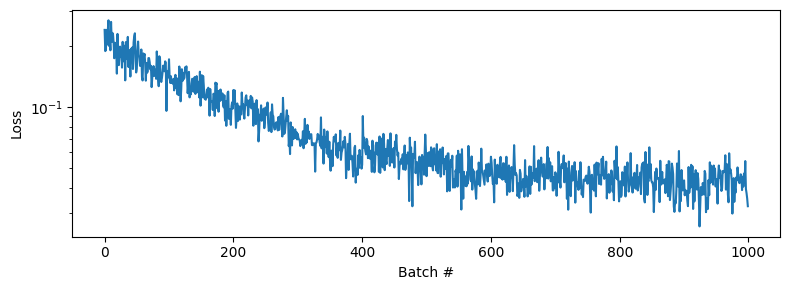

In [ ]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

In [ ]:
from plot import plot_simulations

IndexError: list index out of range

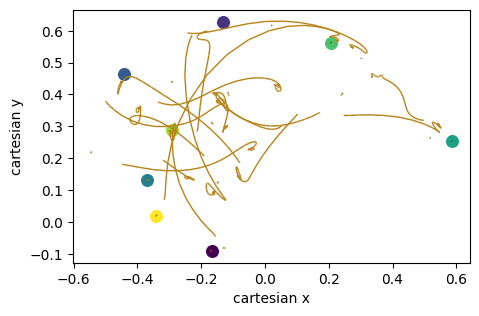

In [ ]:
fg, ax = plt.subplots(nrows=1,ncols=1)
plot_simulations(ax,xy=th.detach(xy),target_xy=th.detach(tg))


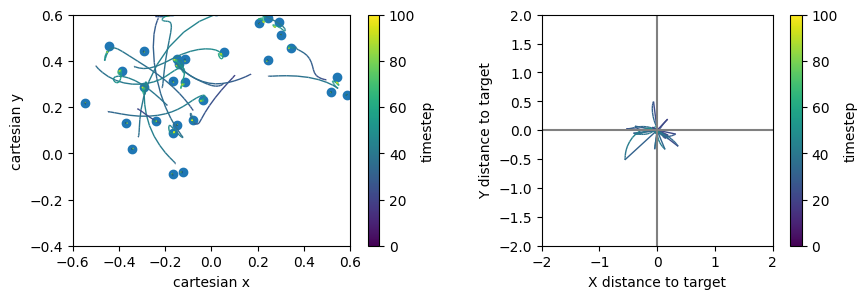

In [ ]:
plot_simulations2(xy = th.detach(xy), target_xy=th.detach(tg))

done.


In [ ]:
timestep = 0.01
muscle_name = 'RigidTendonHillMuscle'  # or 'HillMuscle'
muscle = getattr(mn.muscle,muscle_name)()
effector = mn.effector.RigidTendonArm26(muscle=muscle,timestep=timestep) 

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
# vectorized env 구성
# RecurrentPPO 모델 생성
# vec_env = DummyVecEnv([lambda: env])  # DummyVecEnv는 단일 환경을 벡터화하는 데 사용됩니다.
num_envs = 3
# vec_env = DummyVecEnv([lambda: SB3CentreOutFF(timestep=0.01, muscle_name='RigidTendonHillMuscle',
#                                               condition='train', is_channel=True) 
#                        for _ in range(num_envs)])
vec_env = DummyVecEnv([lambda: SB3CentreOutFF(timestep=0.01, muscle_name='RigidTendonHillMuscle', condition='train', is_channel=True ) for _ in range(num_envs)])

model = RecurrentPPO("MlpLstmPolicy", vec_env, verbose=1,
                    #  tensorboard_log="./sb3_recurrent_tensorboard/",
                     learning_rate=3e-4,
                     n_steps=128,    # on-policy rollout 길이. 환경 특성에 맞게 조정
                     batch_size=64,
                     n_epochs=10,
                     gamma=0.99,
                     clip_range=0.2)
model.learn(total_timesteps=200_000)
model.save("recurrent_ppo_centreout")
